In [2]:
import ContinuityImprovement as CI
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

####  A simple example
$$
\begin{cases}
x_{1,t} &= 3.4x_{1,t-1}(1-x_{1,t-1}^2)e^{-x_{1,t-1}^2}+0.4\eta_{1,t}\\
x_{2,t} &= 3.4x_{2,t-1}(1-x_{2,t-1}^2)e^{-x_{2,t-1}^2}+0.5x_{1,t-1}x_{2,t-1}+0.4\eta_{2,t}\\
x_{3,t} &= 3.4x_{3,t-1}(1-x_{3,t-1}^2)e^{-x_{3,t-1}^2}+0.3x_{2,t-1}+0.5x_{1,t-1}^2+0.4\eta_{3,t}
\end{cases}
$$

In [7]:
np.random.seed(0)
X0 = np.random.random((5,3))
X = np.zeros((1000,3))
for i in range(1000):
    if i == 0:
        X[0] = X0[0]
        continue
    X[i,0] = 3.4*X[i-1,0]*(1-X[i-1,0]**2)*np.exp(-X[i-1,0]**2) + 0.4*np.random.randn()
    X[i,1] = 3.4*X[i-1,1]*(1-X[i-1,1]**2)*np.exp(-X[i-1,1]**2) + 0.5*X[i-1,0]*X[i-1,1] + 0.4*np.random.randn()
    X[i,2] = 3.4*X[i-1,2]*(1-X[i-1,2]**2)*np.exp(-X[i-1,2]**2) + 0.3*X[i-1,1]+0.5*X[i-1,0]**2 + 0.4*np.random.randn()

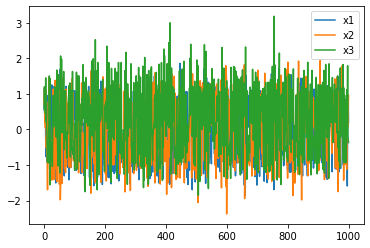

X1-range : -1.854 ~ 1.858 ,  average: -0.038
X2-range : -2.375 ~ 1.941 ,  average: -0.022
X3-range : -1.851 ~ 3.184 ,  average: 0.256


In [8]:
for i in range(3):
    plt.plot(X[:1000,i], label='x'+str(i+1))
plt.legend()
plt.show()
print('X1-range : %.3f ~ %.3f ,  average: %.3f' %(min(X[:,0]), max(X[:,0]), X[:,0].mean()))
print('X2-range : %.3f ~ %.3f ,  average: %.3f' %(min(X[:,1]), max(X[:,1]), X[:,1].mean()))
print('X3-range : %.3f ~ %.3f ,  average: %.3f' %(min(X[:,2]), max(X[:,2]), X[:,2].mean()))

### We provide two types of ContinuityImprovment method in Python
##### 1.Standard:~~  The most original version to execute our proposed algorithm
##### 2.Parallel:~~  An accelerated parallel-based implementation based on Standard version 

#####   Scaling each time series to the same range is important in this case because of amplitude differences

####  true couplings 
$x_{1,t-1}\to x_{2,t}$    
$x_{1,t-1}\to x_{3,t}$    
$x_{2,t-1}\to x_{3,t}$

In [9]:
import time
start_t = time.time()
Causalmodel = CI.StandardContinuityImprove(time_window=5, pred_horizon=1, n_latent=0.99, random_state=2024,model='PCA')
val_m, sign_m = Causalmodel.run_mci(X, R=20, advanced_select=True, scale=False)
end_t = time.time()
print('time cost : %.5f sec' %(end_t-start_t))
print('causal network')
print((sign_m<=0.05).astype('int'))
print('causal effect')
print(np.round(val_m,3))
print('causal delay')
print(Causalmodel.MCI_delaymatrix)

100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

time cost : 3.45505 sec
causal network
[[0 1 1]
 [0 0 0]
 [0 0 0]]
causal effect
[[0.    0.021 0.047]
 [0.    0.    0.007]
 [0.003 0.    0.   ]]
causal delay
{1: [[], [], [3]], 2: [[1], [], []], 3: [[1], [1], []]}


In [10]:
# n_jobs :  the number of parallel threads
import time
start_t = time.time()
Causalmodel = CI.ParallelContinuityImprove(time_window=5, pred_horizon=1, n_latent=0.99, random_state=2024,model='PCA',n_jobs=5)
val_m, sign_m = Causalmodel.run_mci(X, R=20, advanced_select=True, scale=True)
end_t = time.time()
print('time cost : %.5f sec' %(end_t-start_t))
print((sign_m<=0.05).astype('int'))
print(np.round(val_m,3))
print(Causalmodel.MCI_delaymatrix)

100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

time cost : 2.05735 sec
[[0 1 1]
 [0 0 1]
 [0 0 0]]
[[0.    0.02  0.027]
 [0.    0.    0.02 ]
 [0.    0.    0.   ]]
{1: [[], [], []], 2: [[1], [], []], 3: [[2, 1], [1], []]}


### single pair causal inference

In [11]:
cii, alpha, dis_r, dis_f, delay = Causalmodel.onepair_test(X[:,0], X[:,2], [X[:,1]], R=20, scale=True)

In [12]:
print('causal effect: %.4f   p-value: %.4f' %(cii, alpha))
print('causal delay:')
for l in range(len(delay)):
    print(delay[l])

causal effect: 0.0493   p-value: 0.0000
causal delay:
1


### test the premise of Continuity causality

In [8]:
index = Causalmodel.premise_test(X[:,0], X[:,2], [X[:,1]], R=20, scale=True)
for i in range(len(index)):
    print('Continuity index of map from reduced embedding to the effect at time delay'+str(Causalmodel.time_window-i)+':  ', index[i])

Continuity index of map from reduced embedding to the effect at time delay5:   0.0
Continuity index of map from reduced embedding to the effect at time delay4:   0.0
Continuity index of map from reduced embedding to the effect at time delay3:   0.0
Continuity index of map from reduced embedding to the effect at time delay2:   0.0
Continuity index of map from reduced embedding to the effect at time delay1:   0.0


## coupled Logistic system

In [2]:
def coupledLogistic(x0, N, alpha12, alpha21):
    x1 = np.zeros(N+x0.shape[0])
    x2 = np.zeros(N+x0.shape[0])
    for i in range(N+x0.shape[0]):
        if i < x0.shape[0]:
            x1[i] = x0[i,0]
            x2[i] = x0[i,1]
        else:
            x1[i] = x1[i-1]*(3.8-3.8*x1[i-1] - alpha12*x2[i-1])
            x2[i] = x2[i-1]*(3.6-3.6*x2[i-1] - alpha21*x1[i-1]) # 1
            # x2[i] = x2[i-1]*(3.6-3.6*x2[i-1] - alpha21*x1[i-4]) # 4


    return x1[x0.shape[0]:], x2[x0.shape[0]:]

In [3]:
np.random.seed(2024)
x0 = np.random.rand(4,2)*0.5
# print(x0)

### test the premise of Continuity causality

##### Failure of separating the cause

In [90]:
x1, x2 = coupledLogistic(x0, 2048, 0.35, 0.1)
Causalmodel = CI.ParallelContinuityImprove(time_window=5, pred_horizon=1, n_latent=0.99, random_state=2024,model='PCA',n_jobs=5)
index = Causalmodel.premise_test(x2, x1, [], R=10)

for i in range(len(index)):
    print('Continuity index of map from reduced embedding to the effect at time delay'+str(Causalmodel.time_window-i)+':  ', index[i])

Continuity index of map from reduced embedding to the effect at time delay5:   0.9932913398063818
Continuity index of map from reduced embedding to the effect at time delay4:   0.9900299102691925
Continuity index of map from reduced embedding to the effect at time delay3:   0.9949307654622663
Continuity index of map from reduced embedding to the effect at time delay2:   0.9900199600798403
Continuity index of map from reduced embedding to the effect at time delay1:   0.9932913398063818


In [58]:
cii, alpha, dis_r, dis_f, delay = Causalmodel.onepair_test(x2, x1, [], R=10)
print('causal effect: %.4f   p-value: %.4f' %(cii, alpha))
print('causal delay:')
for l in range(len(delay)):
    print(delay[l])

causal effect: 0.0000   p-value: 1.0000
causal delay:


In [91]:
index = Causalmodel.premise_test(x1, x2, [], R=10)

for i in range(len(index)):
    print('Continuity index of map from reduced embedding to the effect at time delay'+str(Causalmodel.time_window-i)+':  ', index[i])

Continuity index of map from reduced embedding to the effect at time delay5:   0.9799947894211184
Continuity index of map from reduced embedding to the effect at time delay4:   0.9825155243633539
Continuity index of map from reduced embedding to the effect at time delay3:   0.9799837619236643
Continuity index of map from reduced embedding to the effect at time delay2:   0.984119012117278
Continuity index of map from reduced embedding to the effect at time delay1:   0.9832748269820145


In [92]:
cii, alpha, dis_r, dis_f, delay = Causalmodel.onepair_test(x1, x2, [], R=10, scale=False)
print('causal effect: %.4f   p-value: %.4f' %(cii, alpha))
print('causal delay:')
for l in range(len(delay)):
    print(delay[l])

causal effect: 0.0000   p-value: 1.0000
causal delay:


##### The premise holds

In [20]:
x1, x2 = coupledLogistic(x0, 2048, 0.25, 0.1)
Causalmodel = CI.ParallelContinuityImprove(time_window=5, pred_horizon=1, n_latent=0.99, random_state=2024,model='PCA',n_jobs=5)
index = Causalmodel.premise_test(x2, x1, [], R=10)

for i in range(len(index)):
    print('Continuity index of map from reduced embedding to the effect at time delay'+str(Causalmodel.time_window-i)+':  ', index[i])

Continuity index of map from reduced embedding to the effect at time delay5:   0.7475891357592082
Continuity index of map from reduced embedding to the effect at time delay4:   0.6140091619690284
Continuity index of map from reduced embedding to the effect at time delay3:   0.6235373894484367
Continuity index of map from reduced embedding to the effect at time delay2:   0.607281637980776
Continuity index of map from reduced embedding to the effect at time delay1:   0.610158891810837


In [28]:
cii, alpha, dis_r, dis_f, delay = Causalmodel.onepair_test(x2, x1, [], R=10)
print('causal effect: %.4f   p-value: %.4f' %(cii, alpha))
print('causal delay:')
for l in range(len(delay)):
    print(delay[l])

causal effect: 0.8475   p-value: 0.0000
causal delay:
2


In [30]:
index = Causalmodel.premise_test(x1, x2, [], R=10)

for i in range(len(index)):
    print('Continuity index of map from reduced embedding to the effect at time delay'+str(Causalmodel.time_window-i)+':  ', index[i])

Continuity index of map from reduced embedding to the effect at time delay5:   0.572511197718474
Continuity index of map from reduced embedding to the effect at time delay4:   0.6882900299706896
Continuity index of map from reduced embedding to the effect at time delay3:   0.5652386434356516
Continuity index of map from reduced embedding to the effect at time delay2:   0.6877866816447485
Continuity index of map from reduced embedding to the effect at time delay1:   0.6254727917998061


In [31]:
cii, alpha, dis_r, dis_f, delay = Causalmodel.onepair_test(x1, x2, [], R=10)
print('causal effect: %.4f   p-value: %.4f' %(cii, alpha))
print('causal delay:')
for l in range(len(delay)):
    print(delay[l])

causal effect: 0.9375   p-value: 0.0000
causal delay:
5
1


# There is a problem about the time window.
### Exactly, if you set time window W large, the information of the cause could be completely recovered by the delay coordinate of the effect. Hence, you cannot detect the coupling.
#### see the example below (a very strong coupling from X2 to X1 while no link in the opposite direction)

##### set time window W = 1, we can detect causality both sides in strong coupling cases, because the premise holds

In [9]:
x1, x2 = coupledLogistic(x0, 2048, 0.8, 0.0)
Causalmodel = CI.ParallelContinuityImprove(time_window=1, pred_horizon=1, n_latent=1, random_state=2024,model=None,n_jobs=5)
index = Causalmodel.premise_test(x2, x1, [], R=10)

for i in range(len(index)):
    print('Continuity index of map from reduced embedding to the effect at time delay'+str(Causalmodel.time_window-i)+':  ', index[i])

cii, alpha, dis_r, dis_f, delay = Causalmodel.onepair_test(x2, x1, [], R=10)
print('x2->x1  causal effect: %.4f   p-value: %.4f' %(cii, alpha))
print('causal delay:')
for l in range(len(delay)):
    print(delay[l])

index = Causalmodel.premise_test(x1, x2, [], R=10)

for i in range(len(index)):
    print('Continuity index of map from reduced embedding to the effect at time delay'+str(Causalmodel.time_window-i)+':  ', index[i])

cii, alpha, dis_r, dis_f, delay = Causalmodel.onepair_test(x1, x2, [], R=10)
print('x1->x2  causal effect: %.4f   p-value: %.4f' %(cii, alpha))
print('causal delay:')
for l in range(len(delay)):
    print(delay[l])

Continuity index of map from reduced embedding to the effect at time delay1:   0.37450038929404594
x2->x1  causal effect: 0.7911   p-value: 0.0000
causal delay:
1
Continuity index of map from reduced embedding to the effect at time delay1:   0.29528120465625074
x1->x2  causal effect: 0.0000   p-value: 1.0000
causal delay:


##### set time window W = 2, we cannot detect true causality in strong coupling cases, because of the failure of the premise (commonly known as generalized synchrony in this situation)

In [10]:
x1, x2 = coupledLogistic(x0, 2048, 0.8, 0.0)
Causalmodel = CI.ParallelContinuityImprove(time_window=2, pred_horizon=1, n_latent=1, random_state=2024,model=None,n_jobs=5)
index = Causalmodel.premise_test(x2, x1, [], R=10)

for i in range(len(index)):
    print('Continuity index of map from reduced embedding to the effect at time delay'+str(Causalmodel.time_window-i)+':  ', index[i])

cii, alpha, dis_r, dis_f, delay = Causalmodel.onepair_test(x2, x1, [], R=10)
print('x2->x1  causal effect: %.4f   p-value: %.4f' %(cii, alpha))
print('causal delay:')
for l in range(len(delay)):
    print(delay[l])

index = Causalmodel.premise_test(x1, x2, [], R=10)

for i in range(len(index)):
    print('Continuity index of map from reduced embedding to the effect at time delay'+str(Causalmodel.time_window-i)+':  ', index[i])

cii, alpha, dis_r, dis_f, delay = Causalmodel.onepair_test(x1, x2, [], R=10)
print('x1->x2  causal effect: %.4f   p-value: %.4f' %(cii, alpha))
print('causal delay:')
for l in range(len(delay)):
    print(delay[l])

Continuity index of map from reduced embedding to the effect at time delay2:   0.976979610073653
Continuity index of map from reduced embedding to the effect at time delay1:   0.9679172723079797
x2->x1  causal effect: 0.0000   p-value: 1.0000
causal delay:
Continuity index of map from reduced embedding to the effect at time delay2:   0.26793026041221574
Continuity index of map from reduced embedding to the effect at time delay1:   0.3040003791051149
x1->x2  causal effect: 0.0000   p-value: 1.0000
causal delay:


#### Therefore, you can choose a proper time window so that the premise can hold.